In [2]:
import itertools
import numpy as np
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import KetSugar as ks
import MaxLik as ml
import HammerProj as hp
import tqdm

SAMPLING_KEY = 'n30'
TEST_KEY_SAMPLING = 'n108' 
ML_ITERS = 10000
ML_THR = 1e-12

rotations_tomo_proj = np.array((
    (0,0),
    (np.pi,0),
    (np.pi/2, 0),
    (np.pi/2, np.pi),
    (np.pi/2, 1*np.pi/2),
    (np.pi/2, 3*np.pi/2)
))

def get_assumed_rpv(errors):
    coords = rotations_tomo_proj + errors.reshape((6,2))
    proj_kets = [ks.BlochKet(theta, phi) for theta, phi in coords]
    return np.array([ket @ ket.T.conjugate() for ket in proj_kets])

mapping2 = lambda coords: hp.Hammer(*hp.BlochToGeo(*coords))

optim_results = np.genfromtxt('results_n30.txt')
test_data = np.load('test_data_n30_5sigma.npz')
true_parameters = test_data['truths']
tomograms = test_data['test_data']
sampling = np.load('probes_samplings.npz')[SAMPLING_KEY]
sel = optim_results[:,1] < 0.005 #pick successfull runs

rhos_prob = np.load('_temp_rhos_n30.npy')
rhos_test = np.load('_temp_rhos_n108_test.npy')

MaxLik: Numba Allowed: True => use cycle-based K-vector construction


In [3]:
#Figure 1
truth = true_parameters[1] #pick first tested case as an example
# Print simulation parameters
DEG = np.pi/180.
text = '('+', '.join([f'{x/DEG:.1f}' for x in truth])+')'
print(text)


true_rpv = get_assumed_rpv(truth)
naive_rpv = get_assumed_rpv(np.zeros_like(truth))

samples = 41
fig_thetas = np.linspace(1e-3,np.pi-1e-3,samples)
fig_phis = np.linspace(-np.pi,np.pi,samples)

xyz = []
for theta, phi in tqdm.tqdm_notebook(itertools.product(fig_thetas, fig_phis), total=samples*samples):
    ket = ks.BlochKet(theta, phi)
    tomogram = np.array([ks.ExpectationValue(ket, pi) for pi in true_rpv])
    rho = ml.Reconstruct(tomogram, naive_rpv, 1000, 1e-9, RhoPiVect=True, Renorm=True)
    purity = ks.Purity(rho).real
    xy = hp.Hammer(*hp.BlochToGeo(theta, phi))
    xyz.append((*xy, purity))
xyz = np.array(xyz)
np.save('_fig_1_data.npy', xyz)

(4.0, 0.8, 8.9, 1.0, -4.2, 3.5, -3.2, -0.8, -12.2, -0.8, 3.0, -3.0)


C:\Users\admin\AppData\Local\Temp\ipykernel_6404\3482815943.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for theta, phi in tqdm.tqdm_notebook(itertools.product(fig_thetas, fig_phis), total=samples*samples):


  0%|          | 0/1681 [00:00<?, ?it/s]

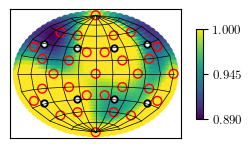

In [4]:
%matplotlib inline

mpl.rcParams['text.usetex'] = True #False
# Set the font family (you may adjust this to your preference)
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['font.serif'] = ['Times New Roman']
# set the font size to match the main text (adjust the value as needed)
mpl.rcParams['font.size'] = 9
# Set the line width for the plot
mpl.rcParams['lines.linewidth'] = 1.5
# Set the figure size for a single-column plot (adjust the width and height as needed)
mpl.rcParams['figure.figsize'] = (3.5, 2.5)


vmin = np.round(np.min(xyz[:,2]),2)
vmax = 1
xyz = np.load('_fig_1_data.npy')
s1 = sampling
s2 = np.load('probes_samplings.npz')["n8"]
xyz_s1 = np.fromiter(map(mapping2, s1), np.dtype([('x', 'f4'), ('y', 'f4')]))
xyz_s2 = np.fromiter(map(mapping2, s2), np.dtype([('x', 'f4'), ('y', 'f4')]))

fig, ax = plt.subplots(1,1, figsize=(3.4,1.4))
       
hp.PlotHammerGrid(ax, 11, 11)        
im = ax.scatter(xyz[:,0], xyz[:,1], s=40, c=xyz[:,2], vmin=vmin, vmax=vmax)
ax.scatter(xyz_s1['x'], xyz_s1['y'], s=40, edgecolors='r', facecolors='none')
ax.scatter(xyz_s2['x'], xyz_s2['y'], marker=".",s=35, lw=3, edgecolors='k', facecolors='k')
ax.scatter(xyz_s2['x'], xyz_s2['y'], marker=".",s=20, lw=1, edgecolors='w', facecolors='w')


ax.set_aspect(1.5)
fig.colorbar(im, ax = ax, shrink=0.7, aspect=20*0.7, ticks = [vmin, vmax, np.round((vmin+vmax)*.5,3)])
ax.set_xticks([])
ax.set_yticks([])
plt.subplots_adjust(top=0.965,
bottom=0.047,
left=0.0,
right=0.885,
hspace=0.2,
wspace=0.2)
plt.show()

In [5]:
#Fig 2
fidelities = []
for dataset_n, dataset_c, dataset_t, dataset_uc in tqdm.tqdm_notebook(rhos_test):
    sub_fidelities = []
    for rho_true, rho_c, rho_uc, rho_n in zip(dataset_t, dataset_c, dataset_uc, dataset_n):
        fn = ks.Fidelity(rho_true, rho_n)
        pn = ks.Purity(rho_n)
        fc = ks.Fidelity(rho_true, rho_c)
        pc = ks.Purity(rho_c)
        fuc = ks.Fidelity(rho_true, rho_uc)
        sub_fidelities.append((fc, fuc, fn, pn, pc))
    fidelities.append(sub_fidelities)

fidelities = np.array(fidelities)

C:\Users\admin\AppData\Local\Temp\ipykernel_6404\564028466.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for dataset_n, dataset_c, dataset_t, dataset_uc in tqdm.tqdm_notebook(rhos_test):


  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
## Calculate statistics
test_results_worst = np.min(fidelities, axis=1)
test_results_ptp = np.ptp(fidelities, axis=1)

pur_improvement = test_results_ptp[:,4].real - test_results_ptp[:,3].real
fid_improvement = test_results_worst[:,1].real - test_results_worst[:,2].real
print(f'Delta P: before: {np.mean(test_results_ptp[:,3].real):.3e}+/-{np.std(test_results_ptp[:,3].real):.3e}')
print(f'Delta P: after: {np.mean(test_results_ptp[:,4].real):.3e}+/-{np.std(test_results_ptp[:,4].real):.3e}')
p_after_mean = np.mean(test_results_ptp[:,4].real) 
q1 = np.quantile(test_results_ptp[:,4].real,0.158)
q2 = np.quantile(test_results_ptp[:,4].real,0.842)
dev_down = p_after_mean - q1
dev_up = q2 - p_after_mean
print(f'Delta P: q:: {q1:.3e}--{q2:.3e}')
print(f'Delta P: q:: {q1:.3e}--{q2:.3e}')
print(f'Delta P: after {p_after_mean:.4f}(+{dev_up:.4f}//-{dev_down:.4f})')
print(f'Delta P: improvement mean: {np.mean(pur_improvement):.3e}+/-{np.std(pur_improvement):.3e}')

f_after_mean = np.mean(test_results_worst[:,1].real)
fq1 = np.quantile(test_results_worst[:,1].real,0.158)
fq2 = np.quantile(test_results_worst[:,1].real,0.842)
fdev_down = f_after_mean - fq1
fdev_up = fq2 - f_after_mean
print(f'min F after: {f_after_mean:.4e}(+{fdev_up:.4f}//-{fdev_down:.4f})')

print(f'min F: improvement mean: {np.mean(fid_improvement):.3e}+/-{np.std(fid_improvement):.3e}')
print(f'avg worst fid post opt: {np.mean(test_results_worst[:,1].real):.4f}+/-{np.std(test_results_worst[:,1].real):.4f}')
print(f'avg worst fid pre opt: {np.mean(test_results_worst[:,2].real):.4f}+/-{np.std(test_results_worst[:,2].real):.4f}')

dev_up



Delta P: before: 8.379e-02+/-2.564e-02
Delta P: after: 1.032e-03+/-1.810e-03
Delta P: q:: 3.594e-05--1.880e-03
Delta P: q:: 3.594e-05--1.880e-03
Delta P: after 0.0010(+0.0008//-0.0010)
Delta P: improvement mean: -8.276e-02+/-2.585e-02
min F after: 9.9970e-01(+0.0003//-0.0005)
min F: improvement mean: 3.307e-02+/-1.241e-02
avg worst fid post opt: 0.9997+/-0.0004
avg worst fid pre opt: 0.9666+/-0.0124


0.0008475140826620293

c:\Users\admin\anaconda3\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


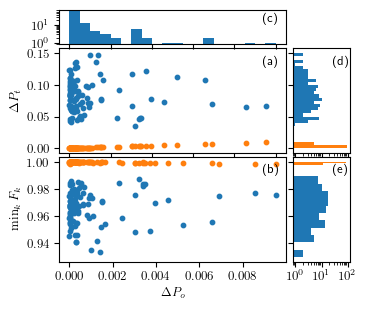

In [7]:
%matplotlib inline
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 9
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.figsize'] = (3.4, 2.5)

test_results_worst = np.min(fidelities, axis=1)
test_results_ptp = np.ptp(fidelities, axis=1)
bins_dp0 = np.linspace(0, 0.01, 21)
bins_dp10 = np.linspace(0, 0.15, 31)
bins_dp11 = np.linspace(0, 0.01, 21)
bins_df = np.linspace(0.93, 1, 14)
bins_df2 = np.linspace(0.99, 1, 11)

fig = plt.figure(figsize=(3.5, 3))
gs = fig.add_gridspec(3, 2,  width_ratios=(4, 1), height_ratios=(1, 3, 3),
                      left=0.16, right=0.99, bottom=0.15, top=0.99,
                      wspace=0.05, hspace=0.05)
axp = fig.add_subplot(gs[1, 0])
axf = fig.add_subplot(gs[2, 0])
axp_histx = fig.add_subplot(gs[0, 0], sharex=axp)
axp_histy = fig.add_subplot(gs[1, 1], sharey=axp)
axf_histy = fig.add_subplot(gs[2, 1], sharey=axf, sharex=axp_histy)
# Draw the scatter plot and marginals.

point_size = 10
axp.scatter(optim_results[:,1], test_results_ptp[:,3], s = point_size, label='pre-optim')
axp.scatter(optim_results[:,1], test_results_ptp[:,4], s = point_size, label='post-optim')

axf.scatter(optim_results[:,1], test_results_worst[:,2], s = point_size, label='pre-optim')
axf.scatter(optim_results[:,1], test_results_worst[:,1], s = point_size, label='post-optim')

axp_histx.hist(optim_results[:,1], bins = bins_dp0, log = True)
axp_histy.hist(test_results_ptp[:,3], bins = bins_dp10, orientation='horizontal', log=True)
axp_histy.hist(test_results_ptp[:,4], bins = bins_dp10, orientation='horizontal', log=True)

axf_histy.hist(test_results_worst[:,2], bins = bins_df, orientation='horizontal', log=True)
axf_histy.hist(test_results_worst[:,1], bins = bins_df2, orientation='horizontal', log=True)

#axf_histy.set_yticks(axf.yaxis.get_ticklocs(), labels=[])
for ax in fig.get_axes():
    ax.label_outer()

axp.set_ylabel('$\Delta P_{t}$')
axf.set_ylabel('$\min_k F_{k}$')
axf.set_xlabel('$\Delta P_{o}$')
axp.text(0.9, 0.85, '(a)', transform=axp.transAxes)
axf.text(0.9, 0.85, '(b)', transform=axf.transAxes)
axp_histx.text(0.9, 0.65, '(c)', transform=axp_histx.transAxes)
axp_histy.text(0.7, 0.85, '(d)', transform=axp_histy.transAxes)
axf_histy.text(0.7, 0.85, '(e)', transform=axf_histy.transAxes)
plt.show()

#orange - test data reconstructed with calibration
#blue - test data reconstructed without calibration